In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import userdata
token =userdata.get('Cryptonite-Token')

In [ ]:
!git config --global user.email "idantsri2007@gmail.com"
!git config --global user.name "SILETRO"

In [ ]:
!git clone https://{token}@github.com/SILETRO/Cryptonite-RTP-Idant.git
%cd Cryptonite-RTP-Idant

In [ ]:
!mkdir Task-5

In [42]:
!cp '/content/drive/MyDrive/Colab Notebooks/The_Office_Generator.ipynb' Task-5/

In [43]:
!git add .

In [44]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   Task-5/The_Office_Generator.ipynb



In [45]:
!git commit -m "Added notebook"
!git push -u origin main

[main bc81e19] Added notebook
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Task-5/The_Office_Generator.ipynb (97%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 68.20 KiB | 6.82 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/SILETRO/Cryptonite-RTP-Idant.git
   638ed7f..bc81e19  main -> main
Branch 'main' set up to track remote branch 'main' from 'origin'.


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '/content/office_script_clean.txt'
text = open(path, 'rb').read().decode(encoding='utf-8')

tf_chars = tf.strings.unicode_split(text, input_encoding='UTF-8')

In [3]:
len(tf_chars)

3427466

In [4]:
char_to_id = tf.keras.layers.StringLookup(  #text to id
    mask_token=None
)
char_to_id.adapt(tf_chars)

id_to_char = tf.keras.layers.StringLookup(  #id to text
    vocabulary=char_to_id.get_vocabulary(),
    invert=True,
    mask_token=None
)

In [6]:
len(char_to_id.get_vocabulary())

73

In [ ]:
char_to_id.get_vocabulary()[:10]

['[UNK]',
 np.str_(' '),
 np.str_('e'),
 np.str_('t'),
 np.str_('o'),
 np.str_('a'),
 np.str_('i'),
 np.str_('n'),
 np.str_('h'),
 np.str_('s')]

In [ ]:
all_ids = char_to_id(tf_chars)
chars_sample = id_to_char(all_ids)

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

n_total = len(all_ids)
n_train = int(n_total * 0.8)
n_val = int(n_total * 0.1)

n_test = n_total - n_train - n_val

train_ds = ids_dataset.take(n_train)
remaining_ds = ids_dataset.skip(n_train)
val_ds = remaining_ds.take(n_val)
test_ds = remaining_ds.skip(n_val)

In [ ]:
seq_length = 300
BATCH_SIZE = 64
BUFFER_SIZE = 10000  # For shuffling memory buffer

def split_input_target(sequence):
    input_text = sequence[:-1]  #take the characters except the target one
    target_text = sequence[1:]  #shift by one character
    return input_text, target_text

train_sequences = train_ds.batch(seq_length + 1, drop_remainder=True) #this splits the train_ds into multiple batches of 251 characters
train_dataset = (train_sequences.map(split_input_target).shuffle(BUFFER_SIZE) #this forms batches according to split_input_target
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val_sequences = val_ds.batch(seq_length + 1, drop_remainder=True)
val_dataset_processed = (val_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_sequences = test_ds.batch(seq_length + 1, drop_remainder=True)
test_dataset_processed = (test_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for x in train_sequences.take(1):
  print(x.shape)

(301,)


In [ ]:
for x,y in train_dataset.take(1):
  print(x.shape)
  print(y.shape)

(64, 300)
(64, 300)


In [ ]:
vocab_size = len(char_to_id.get_vocabulary())
from tensorflow.keras.layers import LSTM
import keras_hub

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=256),
    tf.keras.layers.LSTM(1024, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(1024, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(vocab_size)
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras_hub.metrics.Perplexity(from_logits=True, name="perplexity")]
              )

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "cp_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min'
)

In [ ]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset_processed,
    callbacks=[checkpoint_callback, early_stopping]
)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_perplexity = [np.exp(loss) for loss in train_loss]
val_perplexity = [np.exp(loss) for loss in val_loss]

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 97s 577ms/step - loss: 3.2283 - perplexity: 27.9653 - val_loss: 2.0005 - val_perplexity: 7.3929
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 86s 577ms/step - loss: 1.8103 - perplexity: 6.1270 - val_loss: 1.5842 - val_perplexity: 4.8753
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 86s 579ms/step - loss: 1.4839 - perplexity: 4.4113 - val_loss: 1.4306 - val_perplexity: 4.1811
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - loss: 1.3523 - perplexity: 3.8667 - val_loss: 1.3562 - val_perplexity: 3.8813
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 87s 581ms/step - loss: 1.2758 - perplexity: 3.5816 - val_loss: 1.3150 - val_perplexity: 3.7247
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 87s 579ms/step - loss: 1.2258 - perplexity: 3.4070 - val_loss: 1.2820 - val_perplexity: 3.6038
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 88s 583ms/step - loss: 1.1894 - perplexity: 3.2853 - val_loss: 1.2612 - val_perplexity: 3.5297
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 88s 582ms/step

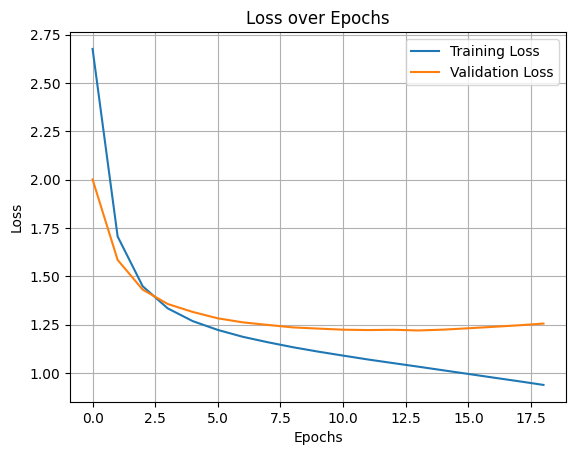

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


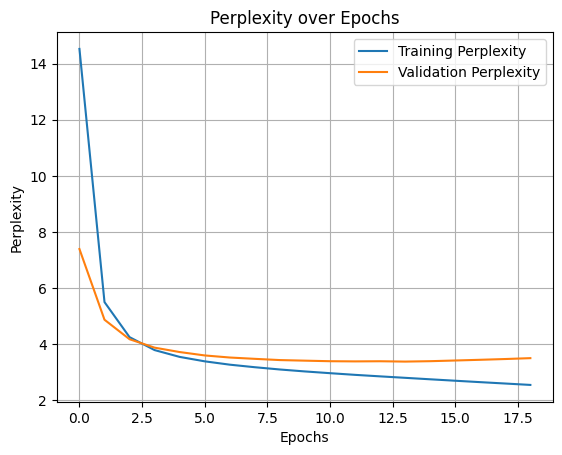

In [ ]:
plt.plot(train_perplexity, label='Training Perplexity')
plt.plot(val_perplexity, label='Validation Perplexity')
plt.title('Perplexity over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.grid(True)
plt.legend()

In [ ]:
model.evaluate(test_dataset_processed)

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 1.2040 - perplexity: 3.3337


[1.2156668901443481, 3.3725428581237793]

In [ ]:
def generate_script(model, seed_text, temperature=1.0, num_tokens_to_generate=1000):
    input_ids = char_to_id(tf.strings.unicode_split(seed_text, 'UTF-8'))
    input_ids = tf.expand_dims(input_ids, 0)

    text_generated = []

    for i in range(num_tokens_to_generate):

        predictions = model(input_ids)  #outputs the probabilities of nect character
        predictions = predictions[:, -1, :] #fetches the last character
        predictions = predictions / temperature

        predicted_id = tf.random.categorical(predictions, num_samples=1)

        input_ids = tf.concat([input_ids, predicted_id], axis=-1)
        text_generated.append(id_to_char(predicted_id))

    return seed_text + tf.strings.reduce_join(text_generated).numpy().decode("utf-8")

seed = "Michael: "

In [31]:
text1 = generate_script(model, seed, temperature=0.5, num_tokens_to_generate=3000)

In [32]:
text1

"Michael: I was thinking about something about the most dogs to get this thing.\nJim:  Hey, Jim. I am going to be done a movie and I can't present the food side.\nAndy: I know what they say. And I brought with us about closing the company. And then I was a little expective to my brother was to be able to talk about that Oscar. I guess I can get you to see her eyes and you are saying you think that you are fine. I was hoping that I would complain in the mail country and I'm completely nice to me. And I have a company that you have a very busy man. And I was just going to be a big deal with a more personal straight. And he made the great thing on the other thing in a corner. So the story were better than anyone who would be a woman here. And I want to say that it was a complete surget of the house. I was in the warehouse. The only one was the only thing that we have come to my private to a website.\nAndy: Yeah.\nDwight: The guns was important to the five minutes and I will be out of my h

In [ ]:
all_ids_text1 = char_to_id(tf.strings.unicode_split(text1, 'UTF-8'))
ids_dataset_text1 = tf.data.Dataset.from_tensor_slices(all_ids_text1)

text1_sequences = ids_dataset_text1.batch(seq_length + 1, drop_remainder=True)
text1_dataset_processed = (
    text1_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=False) # Changed drop_remainder to False
    .prefetch(tf.data.AUTOTUNE)
)

results = model.evaluate(text1_dataset_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step - loss: 0.5516 - perplexity: 1.7360


In [ ]:
text2 = generate_script(model, seed_text = "Pam: ", temperature=0.7, num_tokens_to_generate=3000)

In [ ]:
text2

"Pam: So um, that's what I want to do. You're welcome.\nJim: I'm sure he's my friend, my friend.\nMichael: Not a word for the warehouse. This is so sorry.\nPam:  Hey, hey, hey! Jim.\nJim:  Stealing mom. \nDwight: Have you done my parents like you have it?\nRyan: I'll see you on the hand for a temponist.\nPam: I just didn't know if you wanted to say Jim's pregnant, but I just wanted to know, but I can explain that a great copier.\nJim: Well then, then I got what I have done.\nPam: Okay, well, don't call me what the things got in here.  Can you steal the food at all?\nDwight: I take the money. Just do it.\nMichael: Do you really think that's why you will not do this? I got a lot of money about this year. And you are really interested in our own company. And I got my parents look at a friends. We need more than this connection I will go home. I felt really nervous about hot dogs when they call call off the child's presentation to the best I was a hypocrite game. I don't really do from a b

In [ ]:
all_ids_text2 = char_to_id(tf.strings.unicode_split(text2, 'UTF-8'))
ids_dataset_text2 = tf.data.Dataset.from_tensor_slices(all_ids_text2)

text2_sequences = ids_dataset_text2.batch(seq_length + 1, drop_remainder=True)
text2_dataset_processed = (
    text2_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.AUTOTUNE)
)

results = model.evaluate(text2_dataset_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.7950 - perplexity: 2.2143


In [27]:
text3 = generate_script(model, seed_text = "Jim: ", temperature=1, num_tokens_to_generate=3000)

In [28]:
text3

"Jim: Thanks again.\nMichael: Um, hello, I was thinking about Michael Scott. That's not true. Around States of Dunder Mifflin. But it's been like my head in the whole historic mouths.\nJulia: No this is a lot to bling down into a proft. My diarold game.\nPam: That's mine?\nMichael: Well I mean, Macbiluden, would Jan, you get to like that?\nPam: Dunder Mifflin. Is it high right now?\nAndy: No, no.\nDeangelo: Actually, I'm sick down for kent in Scranton. Some thing I could do to commun with, shut up.\nMichael: That's neat, we... what are you... of course I'm taking my hand. \nPam: Come on nunkin, man, we are so fair.\nMichael: A new receptioniend.\nRyan: Rule. All I brought, I am going to take a cover.\nJim: You're key.\nJan: I...\nStanley: I guess one moving---\nMichael: Baby fantasy is a message.\nCreed: Today's called Fashier's I8, L-W?! I don't think I want you to take me.\nDwight: Have I see a Parable left area?\nJim: If the way I'm forwarding Darryl's future so you haven't asked ab

In [29]:
all_ids_text3 = char_to_id(tf.strings.unicode_split(text3, 'UTF-8'))
ids_dataset_text3 = tf.data.Dataset.from_tensor_slices(all_ids_text3)

text3_sequences = ids_dataset_text3.batch(seq_length + 1, drop_remainder=True)
text3_dataset_processed = (
    text3_sequences.map(split_input_target)
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.AUTOTUNE)
)

results = model.evaluate(text3_dataset_processed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1.0765 - perplexity: 2.9344
